Top trials by mean score:
 fold          1         2         3         4         5      mean
trial                                                            
7      0.823027  0.811083  0.804874  0.812355  0.821732  0.814614
1      0.820671  0.817987  0.806914  0.802594  0.808229  0.811279
6      0.814935  0.820407  0.795954  0.798907  0.816283  0.809298
3      0.815425  0.815873  0.802004  0.801110  0.810555  0.808993
4      0.800427  0.820738  0.801100  0.811922  0.808470  0.808532
2      0.807757  0.823265  0.800238  0.803938  0.804992  0.808038
0      0.813992  0.813695  0.791427  0.797557  0.814863  0.806307
5      0.818777  0.813790  0.794161  0.789529  0.810951  0.805442


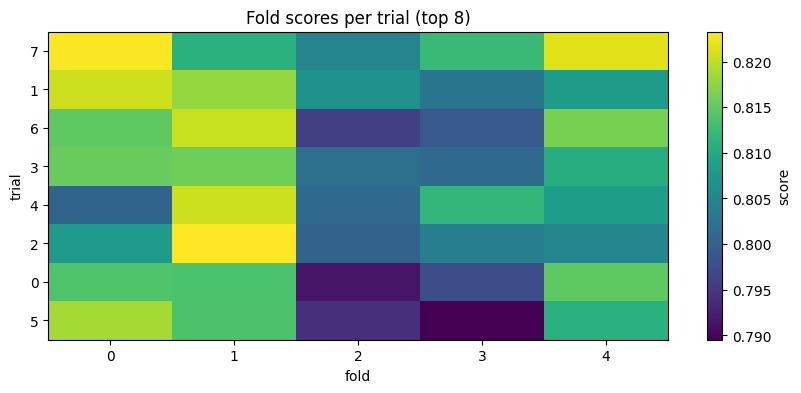

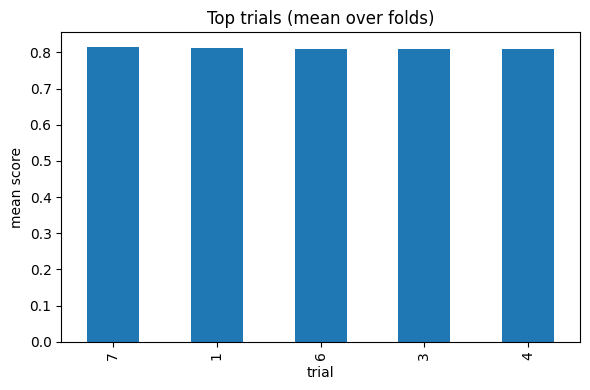

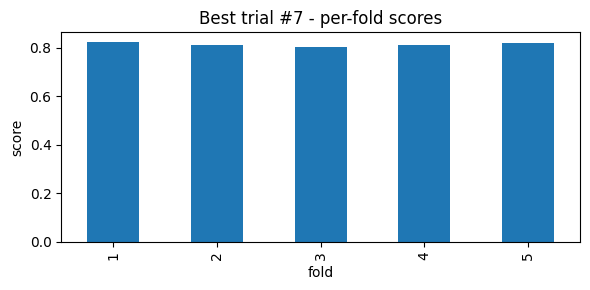

,rank,trial,objective,mean,aug_p_time_shift,aug_max_shift_ratio,aug_p_block_dropout,aug_block_len_max,aug_p_imu_jitter,aug_imu_sigma,aug_p_imu_scale,aug_imu_scale_sigma,aug_p_imu_drift,aug_drift_std,aug_drift_clip,aug_p_imu_small_rot,aug_rot_deg
0,1,7,0.814614,0.814614,0.699636,0.264118,0.127353,6,0.348139,0.020455,0.185508,0.082034,0.271578,0.001189,0.427282,0.328589,5.542853
1,2,1,0.811279,0.811279,0.524319,0.177274,0.082009,5,0.357427,0.018639,0.158246,0.128948,0.277899,0.002753,0.373272,0.364017,6.925880
2,3,6,0.809298,0.809298,0.575463,0.167380,0.163572,6,0.299269,0.011271,0.162196,0.106015,0.395921,0.004825,0.477443,0.368054,3.597971
3,4,3,0.808993,0.808993,0.604053,0.168306,0.119421,5,0.472796,0.015176,0.232504,0.104937,0.354014,0.004280,0.336971,0.492396,6.875664
4,5,4,0.808532,0.808532,0.778825,0.284224,0.131748,6,0.226548,0.013920,0.109045,0.106026,0.327735,0.002628,0.465748,0.339188,4.404673


In [3]:
# ==== 設定 ====
STORAGE = "sqlite:///lstmgru_tuning.db"
STUDY   = "imu_tuning_4"

import optuna, pandas as pd, numpy as np, matplotlib.pyplot as plt
from optuna.trial import TrialState

study = optuna.load_study(study_name=STUDY, storage=STORAGE)

# 1) user_attr から fold_scores(list[float]) を収集
rows = []
for t in study.get_trials(states=(TrialState.COMPLETE,)):
    fs = t.user_attrs.get("fold_scores", None)
    if isinstance(fs, (list, tuple)) and len(fs) > 0:
        for i, s in enumerate(fs, start=1):  # i=fold番号(1始まり)
            rows.append({"trial": t.number, "fold": i, "score": float(s), "objective": t.value})

df = pd.DataFrame(rows)
assert not df.empty, "fold_scores が見つかりません。trial.set_user_attr('fold_scores', list) を確認してください。"

# 2) ピボット（trial×fold）
pv = df.pivot_table(index="trial", columns="fold", values="score", aggfunc="mean")
pv["mean"] = pv.mean(axis=1)

# 3) 上位を確認
top = pv.sort_values("mean", ascending=False)
print("Top trials by mean score:\n", top.head(10))

# 4) ヒートマップ（上位20試行）
top_k = min(20, len(top))
hm = top.iloc[:top_k, :-1]  # 平均列を除外
plt.figure(figsize=(10, max(4, 0.35*top_k)))
plt.imshow(hm, aspect="auto")
plt.title(f"Fold scores per trial (top {top_k})")
plt.xlabel("fold")
plt.ylabel("trial")
plt.colorbar(label="score")
plt.yticks(range(top_k), hm.index.to_list())
plt.show()

# 5) 上位5試行の平均スコア棒グラフ
plt.figure(figsize=(6,4))
top["mean"].head(min(5, len(top))).plot(kind="bar")
plt.ylabel("mean score")
plt.title("Top trials (mean over folds)")
plt.tight_layout()
plt.show()

# 6) ベスト試行の fold別スコアを個別に可視化（任意）
best_trial = int(top.index[0])
plt.figure(figsize=(6,3))
pv.loc[best_trial].drop("mean").plot(kind="bar")
plt.ylabel("score")
plt.title(f"Best trial #{best_trial} - per-fold scores")
plt.tight_layout()
plt.show()

# （必要ならCSV出力）
# pv.to_csv("fold_scores_pivot.csv")

# 3.5) 上位5試行のパラメータ一覧
k = min(5, len(top))  # 上位5（試行が5未満ならその件数）
# trial番号 -> Trial の引き当て辞書
trial_lookup = {t.number: t for t in study.get_trials(states=(TrialState.COMPLETE,))}

records = []
for rank, trial_no in enumerate(top.index[:k], start=1):
    t = trial_lookup[trial_no]
    rec = {
        "rank": rank,
        "trial": trial_no,
        "objective": t.value,                 # 目的関数値
        "mean": float(top.loc[trial_no, "mean"]),  # fold平均
    }
    # パラメータ展開（列として並べる）
    for p_name, p_val in t.params.items():
        rec[p_name] = p_val
    records.append(rec)

params_df = pd.DataFrame(records)
# 列順を見やすく整える
front = ["rank", "trial", "objective", "mean"]
params_df = params_df[front + [c for c in params_df.columns if c not in front]]

# 表示（Jupyter）
try:
    from IPython.display import display
    display(params_df)
except Exception:
    print(params_df)

# 必要なら保存
params_df.to_csv("top5_params.csv", index=False)
